In [18]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np
import dask.dataframe as dd    #dask是用于并行计算
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive #交互式设计
import gc #垃圾回收机制
import joblib #将Python代码转换为并行计算模式的软件包
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union #类型检查，方便使用者调用时传入和返回参数类型，该模块加入后并不会影响程序的运行，不会报正式的错误，只有提醒
from tqdm.notebook import tqdm_notebook as tqdm #显示进度条
from itertools import cycle #反复执行循环
import datetime as dt
from torch.autograd import Variable #包装tensor,使其可以进行反向传播
import random 
import os
from matplotlib.pyplot import figure
from fastprogress.fastprogress import master_bar, progress_bar #进度条输出，同tqdm
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #预处理
import time 
from torch.utils.data import Dataset #pytorch 读取数据集
from sklearn.metrics import mean_squared_error
import torch

%matplotlib inline

#from gensim.models import Word2Vec
#import gensim.downloader as api

pd.set_option('max_columns', 50)
plt.style.use('bmh')
#Display the colors from the default prop_cycle，结果是一个list
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
#可以使用next()对其进行反复迭代
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [34]:
#GPU useage
#device = 'cuda:0'
device = 'cpu'
INPUT_DIR_PATH = '/Users/yanzeliu/Downloads/m5-forecasting-accuracy/'

In [20]:
#verbose=True表示显示时出现详细信息 warning之类的
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    #iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    #df.memory_usage()返回每一列的内存，通过sum()算出总内存，除完后结果是xxMB
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            #[:3]是把'int1XX'后面的数字去掉
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def read_data():
    #读取价格表
    sell_prices_df = pd.read_csv(INPUT_DIR_PATH + 'sell_prices.csv')
    #减少内存
    sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    #读取日历表
    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    #减少日历表内存
    calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    #读取时间序列表
    sales_train_validation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))

    #读取提交表（应该全部为0）
    submission_df = pd.read_csv(INPUT_DIR_PATH + 'sample_submission.csv')
    return sell_prices_df, calendar_df, sales_train_validation_df, submission_df

In [21]:
#load data
_,  calendar_df, sales_train_validation_df, _ = read_data()

Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Sales train validation has 30490 rows and 1919 columns


In [22]:
#Create date index
date_index = calendar_df['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [23]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
sales_train_validation_df['item_store_id'] = sales_train_validation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales_train_validation_df.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = sales_train_validation_df['item_store_id'].values

In [24]:
#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)
DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


In [25]:
SEED = 1345
def seed_everything(seed):
    #使用random()每次生成相同的随机数
    random.seed(seed)
    #主目录环境变量，使hash可以复现
    os.environ['PYTHONHASHSEED'] = str(seed)
    #使用np.random()每次生成相同的随机数
    np.random.seed(seed)
    #神经网络参数初始化，使深度学习结果可以复现
    torch.manual_seed(seed)
    #神经网络参数初始化，使深度学习结果可以复现
    torch.cuda.manual_seed(seed)
    #保证相同初始化下，结果都是一样的
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

In [26]:
#选择某一个时间序列进行操作
index = 1000
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index)

#normalize the data
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [27]:
#创造时间序列（通过滑窗）
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [28]:
#应用方程创造（单指某一个time series)
seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

(1884, 28, 1)
(1884, 1)


In [29]:
#划分训练集和测试集,我查了一下，好像variable这个函数被取消了，现在是直接用tensor比较多，另外可以用datasetload
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [30]:
#检查训练集和测试集
print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1262, 28, 1])
train label shape is: torch.Size([1262, 1])
test shape is: torch.Size([622, 28, 1])
test label shape is: torch.Size([622, 1])


In [31]:
#创建一个LSTM类
# 继承 torch 的 Module
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        # 继承 __init__ 功能
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        # 定义每层用什么样的形式 主要需要改动的地方
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    #定义正向传播的过程
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

The following parameters are provided to the net

Num-classes - is the number of output in this case
Input size - we don't use batch, so we have one input (of 28 samples)
Hidden layers, number of hidden layer in each cell, the more is better, but also will slow down the training
Num layers - we have one layer of LSTM (layer we will increase it)

In [ ]:
# create a nn class (just-for-fun choice :-) 应该可以直接用现成的MSELoss改造
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [32]:
#####  Parameters  ######################
num_epochs = 500
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

In [35]:
#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

LSTM(
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(1, 512, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [36]:
##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
#scheduler指的是经过多少次迭代，学习率改变一次
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

In [37]:
# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

Epoch: 0, loss: 0.51023 valid loss:  0.56968 
Epoch: 50, loss: 0.15415 valid loss:  0.11399 
Epoch: 100, loss: 0.15727 valid loss:  0.11539 
Epoch: 150, loss: 0.14768 valid loss:  0.11530 
Epoch: 200, loss: 0.16289 valid loss:  0.11581 
Epoch: 250, loss: 0.15621 valid loss:  0.11374 
Epoch: 300, loss: 0.15879 valid loss:  0.11306 
Epoch: 350, loss: 0.14696 valid loss:  0.11108 
Epoch: 400, loss: 0.15271 valid loss:  0.11122 
Epoch: 450, loss: 0.15454 valid loss:  0.10798 


In [41]:
######Prediction###############

lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

In [42]:
## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

In [43]:
## Add dates

df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

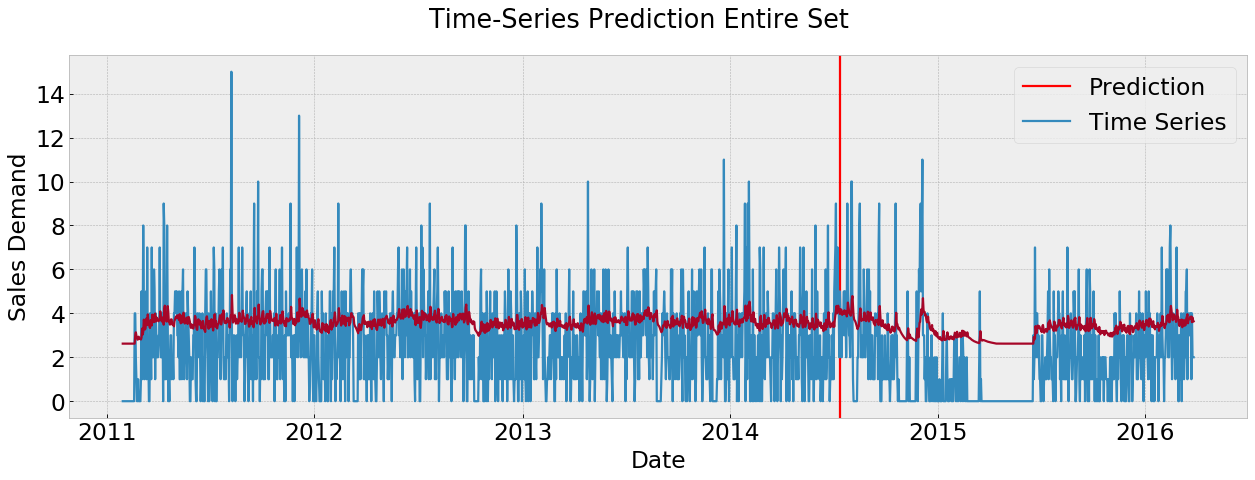

In [44]:
# Plot 先做一组看看结果到底是什么样的，和之前做的lstm是否一样

figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

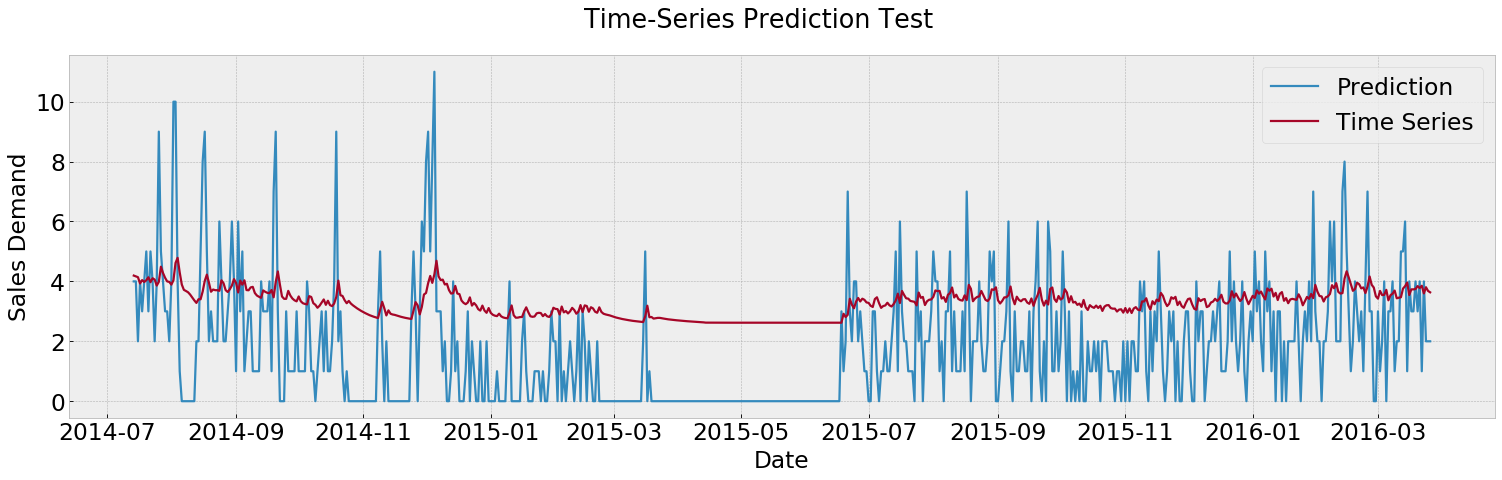

In [45]:
#######Plot the test set ##########################

figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [46]:
#自己定义的loss应该是在反向传播的时候用的，test直接用np计算就可以

np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

2.3310688

In [ ]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
       
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

In [ ]:
def init_weights(m):
    # named_prapmeters是给出参数的迭代器
    for name, param in m.named_parameters():
        #提取出参数并将用.data其转化为tensor,然后使用uniform将其初始化
        nn.init.uniform_(param.data, -0.08, 0.08)

In [ ]:
num_epochs = 700
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 2

num_classes = 1

lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)


lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    scheduler.step(loss)
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

In [ ]:
######Prediction###############


lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [ ]:
#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()